In [32]:
# Librerie necessarie
library(tools)  # Per la funzione file_path_sans_ext
library(fs)     # Per le funzioni di gestione dei file

# Definizione delle directory di input e output
dataDir <- "dataset/rawdataset"
GEO <- "."
datasetDir <- file.path(dataDir, "GSE194078_RAW")
outputDir <- file.path(dataDir, "organized_data_gse194078")

untar(tarfile = file.path(dataDir, "GSE194078_RAW.tar"), exdir = dataDir)

extract_prefix <- function(filename) {
  sub("(_barcodes.tsv.gz|_genes.tsv.gz|_matrix.mtx.gz|_features.tsv.gz)", "", filename)
}
files = list.files(datasetDir)
dir_create(outputDir)


In [33]:
organize_files <- function(datasetDir, files, outputDir) {
  prefixes <- unique(sapply(files, extract_prefix))
  
  for (single_prefix in prefixes) {
    
    barcode_file <- file.path(datasetDir, paste0(single_prefix, "_barcodes.tsv.gz"))
    gene_file <- file.path(datasetDir, paste0(single_prefix, "_features.tsv.gz"))
    matrix_file <- file.path(datasetDir, paste0(single_prefix, "_matrix.mtx.gz"))
    print(barcode_file)
    
    # Crea la cartella se non esiste già
    folder_path <- file.path(outputDir, single_prefix)
    print(folder_path)
    dir_create(folder_path, recurse = TRUE)
    
    # Rinomina e copia il file nella cartella corretta
    #new_filename <- paste0(prefix, ".", ext)
    file_copy(barcode_file, file.path(folder_path, "barcodes.tsv"), overwrite = TRUE)
    file_copy(gene_file, file.path(folder_path, "genes.tsv"), overwrite = TRUE)
    file_copy(matrix_file, file.path(folder_path, "matrix.mtx"), overwrite = TRUE)
    
    
  }
}
organize_files(datasetDir,files, outputDir)

[1] "dataset/rawdataset/GSE194078_RAW/GSM5827375_CYG_CSF_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827375_CYG_CSF"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827376_CYG_PBMC_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827376_CYG_PBMC"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827377_JSB_CSF_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827377_JSB_CSF"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827378_JSB_PBMC_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827378_JSB_PBMC"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827379_JYJ_CSF_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827379_JYJ_CSF"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827380_JYJ_PBMC_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827380_JYJ_PBMC"
[1] "dataset/rawdataset/GSE194078_RAW/GSM5827381_KHW_CSF_barcodes.tsv.gz"
[1] "dataset/rawdataset/organized_data_gse194078/GSM5827381_KH

In [34]:
# LOADING SERIES DATA
library(GEOquery)
gse_id <- "GSE194078"
gse <- getGEO(gse_id)
gse <- gse$GSE194078_series_matrix.txt.gz
sample_metadata <- pData(gse)
#keep what we need
columns_to_keep <- c("title", "geo_accession", "disease:ch1", "patient id:ch1", "tissue:ch1")
sample_metadata <- sample_metadata[,columns_to_keep]


Found 1 file(s)

GSE194078_series_matrix.txt.gz

Using locally cached version: /tmp/RtmptSPm38/GSE194078_series_matrix.txt.gz

Using locally cached version of GPL20795 found here:
/tmp/RtmptSPm38/GPL20795.soft.gz 



In [35]:
library(Seurat)
library(Matrix)
library(dplyr)  # Ensure this is loaded for %>%
library(Azimuth)
options(Seurat.object.assay.version = "v3") # Forziamo la versione 3 degli oggetti seurat. Conviene.
options(Seurat.object.assay.calcn = TRUE) 

In [36]:
plot_qc <- function(dataset, groupby, outputfile, length){
  #some plot 
  qc_features <- c("nFeature_RNA", "nCount_RNA", "percent.mt")
  plot_list <- list()
  library(ggplot2)
  library(cowplot)
  
  for (feature in qc_features) {
    # Generate a violin plot for the current feature
    plot <- VlnPlot(dataset, features = feature, group.by = groupby, pt.size = 0.1) +
      ggtitle(feature) +theme(
        axis.title = element_text(hjust = 0.5,size = 25),  # Axis titles size
        axis.text = element_text(size =30),   # Axis tick labels size
        plot.title = element_text(size = 30)   # Plot title size
      )
    
    # Store the plot in the list
    plot_list[[feature]] <- plot
  }
  combined_plot <- plot_grid(plotlist = plot_list, ncol = 1, align = "v")
  ggsave(outputfile, plot= combined_plot, width=100, height=5*length, dpi=150, limitsize=FALSE)
  
}

In [37]:
read_10x_data <- function(folder_path) {
  # Chiamata a Read10X con i file corretti
  data <- Read10X(data.dir = folder_path)
  
  # Crea un oggetto Seurat con i dati letti
  seurat_obj <- CreateSeuratObject(counts = data, 
                                   assay = "RNA")
  print(seurat_obj)
  return(seurat_obj)
}

In [38]:
subfolders <- list.dirs(outputDir, full.names = TRUE, recursive = FALSE)
seurat_list <- vector("list", length = length(subfolders))


prefixes <- unique(sapply(files, extract_prefix))

dataset_tags <- sapply(prefixes, function(prefix){
  split_prefix <- strsplit(prefix, "_")[[1]]
  patient_code <- split_prefix[[2]]
  tissue <- split_prefix[[3]]
  paste(patient_code, tissue, sep="_")
})

In [39]:
# Initialize a list to store Seurat objects
seurat_list <- vector("list", length(subfolders))

# Loop through each subfolder
for (i in seq_along(subfolders)) {
  subfolder <- subfolders[i]
  dataset_tag <- dataset_tags[[i]]
  
  cat("Currently processing dataset:", i, "\n")

  # Read 10x data
  seurat_obj <- Read10X(data.dir = subfolder)
  seurat_obj <- CreateSeuratObject(counts = seurat_obj, assay="RNA")

  # Extract metadata
  dataset_parts <- strsplit(dataset_tag, "_")[[1]]
  patient <- dataset_parts[1]
  tissue <- dataset_parts[2]
  
  # Attach metadata to Seurat object
  seurat_obj$orig.ident <- dataset_tag
  seurat_obj$title <- dataset_tag
  
  # Extract additional metadata from sample_metadata
  metadata_row <- sample_metadata[sample_metadata$title == dataset_tag, ]
  seurat_obj$Condition <- metadata_row[['disease:ch1']]
  seurat_obj$Tissue.Type <- metadata_row[['tissue:ch1']]
  seurat_obj$Patient <- metadata_row[['patient id:ch1']]
  
  # Calculate mitochondrial percentage
  seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")
  
  # Calculate nFeature_RNA and nCount_RNA
  seurat_obj$nFeature_RNA <- colSums(seurat_obj@assays$RNA@counts > 0)
  seurat_obj$nCount_RNA <- colSums(seurat_obj@assays$RNA@counts)
      print(seurat_obj)
    print(colnames(seurat_obj@meta.data))
  # Optional: Filter cells based on QC metrics
    seurat_obj <- subset(seurat_obj, subset = nFeature_RNA < 6000 & nCount_RNA < 35000 & percent.mt < 10)
  
  
  # Store the Seurat object in the list
  seurat_list[[i]] <- seurat_obj
}

Currently processing dataset: 1 
An object of class Seurat 
36601 features across 2641 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "title"        "Condition"   
[6] "Tissue.Type"  "Patient"      "percent.mt"  
Currently processing dataset: 2 
An object of class Seurat 
36601 features across 8528 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "title"        "Condition"   
[6] "Tissue.Type"  "Patient"      "percent.mt"  
Currently processing dataset: 3 
An object of class Seurat 
36601 features across 1917 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "title"        "Condition"   
[6] "Tissue.Type"  "Patient"      "percent.mt"  
Currently processin

In [ ]:
merged_data <- merge(seurat_list[[1]], y=seurat_list[-1])
merged_data <- subset(merged_data, subset=Tissue.Type == "PBMC") # ci interessa solo il pbmc qui
# ci interessano solamente i pazienti MS e Normal
merged_data_subset <- subset(merged_data, subset = Condition %in% c("MS", "Normal"))


In [20]:

plot_qc(merged_data_subset, "orig.ident", "preprocessing_gse194078.post.png", 10)


In [40]:
# We can now split by orig.ident and then run azimuth

split_orig_ident <- SplitObject(merged_data_subset, split.by='orig.ident')

# Loop through each split object and run Azimuth
for (i in seq_along(split_orig_ident)) {
  dataset_name <- names(split_orig_ident)[i]
  cat("Processing dataset:", dataset_name, "\n")
  
  # Run Azimuth on the current dataset
  split_orig_ident[[i]] <- RunAzimuth(split_orig_ident[[i]], ref = "pbmcref")
}

Processing dataset: JSB_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"113 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4887 features."
Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 7271 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning mes

Processing dataset: JYJ_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"113 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4887 features."
Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 7693 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning mes

Processing dataset: KJS_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"113 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4887 features."
Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 9847 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning mes

Processing dataset: KYO_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"113 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4887 features."
Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 10788 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning me

Processing dataset: YYW_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"113 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4887 features."
Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 11869 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning me

In [41]:
merged_data <- merge(split_orig_ident[[1]], y=split_orig_ident[-1])

merged_data <- NormalizeData(merged_data)
all.genes <- rownames(merged_data)
merged_data <- ScaleData(merged_data, features = all.genes)

Centering and scaling data matrix



In [42]:
merged_data <- RunPCA(merged_data, features = all.genes)
merged_data <- RunUMAP(merged_data, dims = 1:10)


Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 9410 features requested have zero variance (running reduction without them): MIR1302-2HG, FAM138A, AL627309.2, AP006222.2, AL732372.1, OR4F29, AC114498.1, OR4F16, AL645608.6, LINC02593, AL645608.5, AL391244.1, TMEM88B, LINC01770, AL139246.4, HES5, AC242022.2, AC242022.1, AL592464.2, AL592464.3, AL592464.1, AL589702.1, ACTRT2, AL008733.1, AL590438.1, AL354743.2, AL354743.1, AL512413.1, AL136528.2, LINC01345, LINC02780, AL355602.1, Z98747.1, LINC01646, BX005132.1, LINC02781, LINC02782, AL139823.1, Z98259.3, Z98259.2, Z98259.1, HES3, AL512330.1, Z97987.1, AL365194.1, LINC01714, AL358876.2, BX323043.1, AL928921.1, AL603962.1, AL031291.1, LINC01647, AL953897.1, NPPB, AADACL4, AADACL3, PRAMEF12, PRAMEF1, LINC01784, PRAMEF11, PRAMEF2, PRAMEF4, PRAMEF10, PRAMEF7, PRAMEF6, PRAMEF27, HNRNPCL3, PRAMEF25, HNRNPCL2, AC245056.1, PRAMEF26, HNRNPCL4, PRAMEF9, PRAMEF13, PRAMEF18, PRAMEF5, PRAMEF8, PRAMEF3

ERROR: Error: object 'pbmc' not found


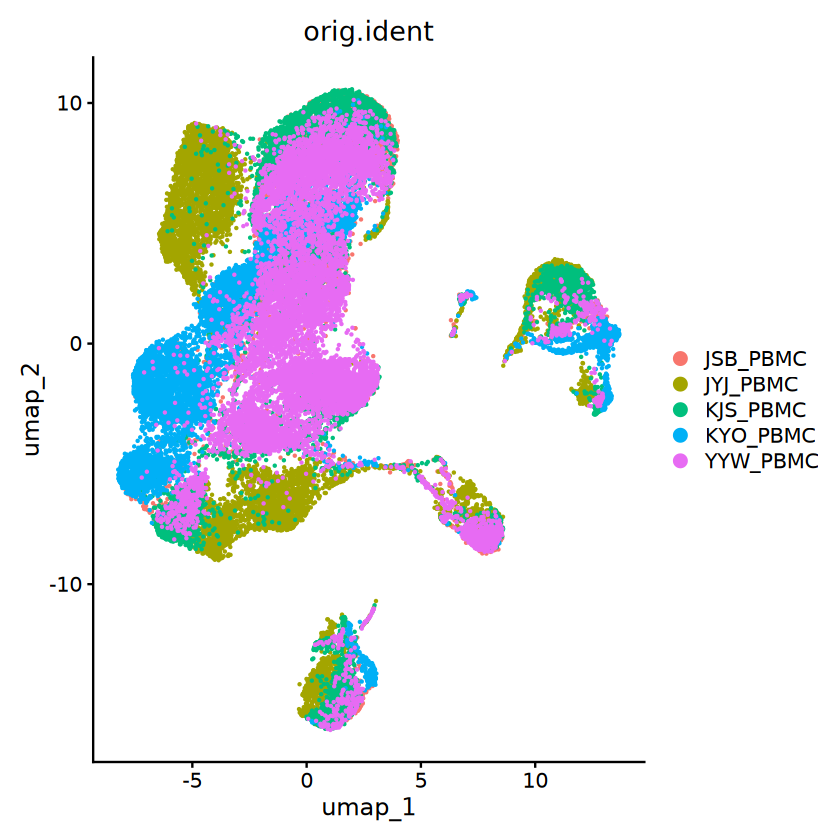

In [43]:
DimPlot(merged_data, reduction = "umap", group.by="orig.ident")

In [44]:
library(Seurat)
library(SeuratDisk)

# Supponendo che `gse144744` sia un oggetto Seurat
SaveH5Seurat(merged_data, filename = "gse194078_pbmc.h5Seurat")
Convert("gse194078_pbmc.h5Seurat", dest = "h5ad")


Attaching package: 'SeuratDisk'


The following object is masked from 'package:Azimuth':

    Connect


Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for prediction.score.celltype.l1

Adding data for prediction.score.celltype.l1

No variable features found for prediction.score.celltype.l1

No feature-level metadata found for prediction.score.celltype.l1

Adding counts for prediction.score.celltype.l2

Adding data for prediction.score.celltype.l2

No variable features found for prediction.score.celltype.l2

No feature-level metadata found for prediction.score.celltype.l2

Adding counts for prediction.score.celltype.l3

Adding data for prediction.score.celltype.l3

No variable features found for prediction.score.celltype.l3

No feature-level metadata found for prediction.score.celltype.l3

Adding cell embeddings for pca

Addin